In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import hermite
import cv2
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

In [59]:
# Update model_function to accept parameters as a single array
def model_function(params, x, y, m, n):
    a, b, c, x_shift, y_shift, z_offset, x_scale, y_scale = params
    x = x_scale * (x - x_shift)  # Shift and scale x
    y = y_scale * (y - y_shift)  # Shift and scale y
    H_m = hermite(m)(x)  # Hermite polynomial of order m
    H_n = hermite(n)(y)  # Hermite polynomial of order n
    return (a * H_m * H_n * np.exp(-b * (x**2 + y**2)) + c) ** 2 + z_offset

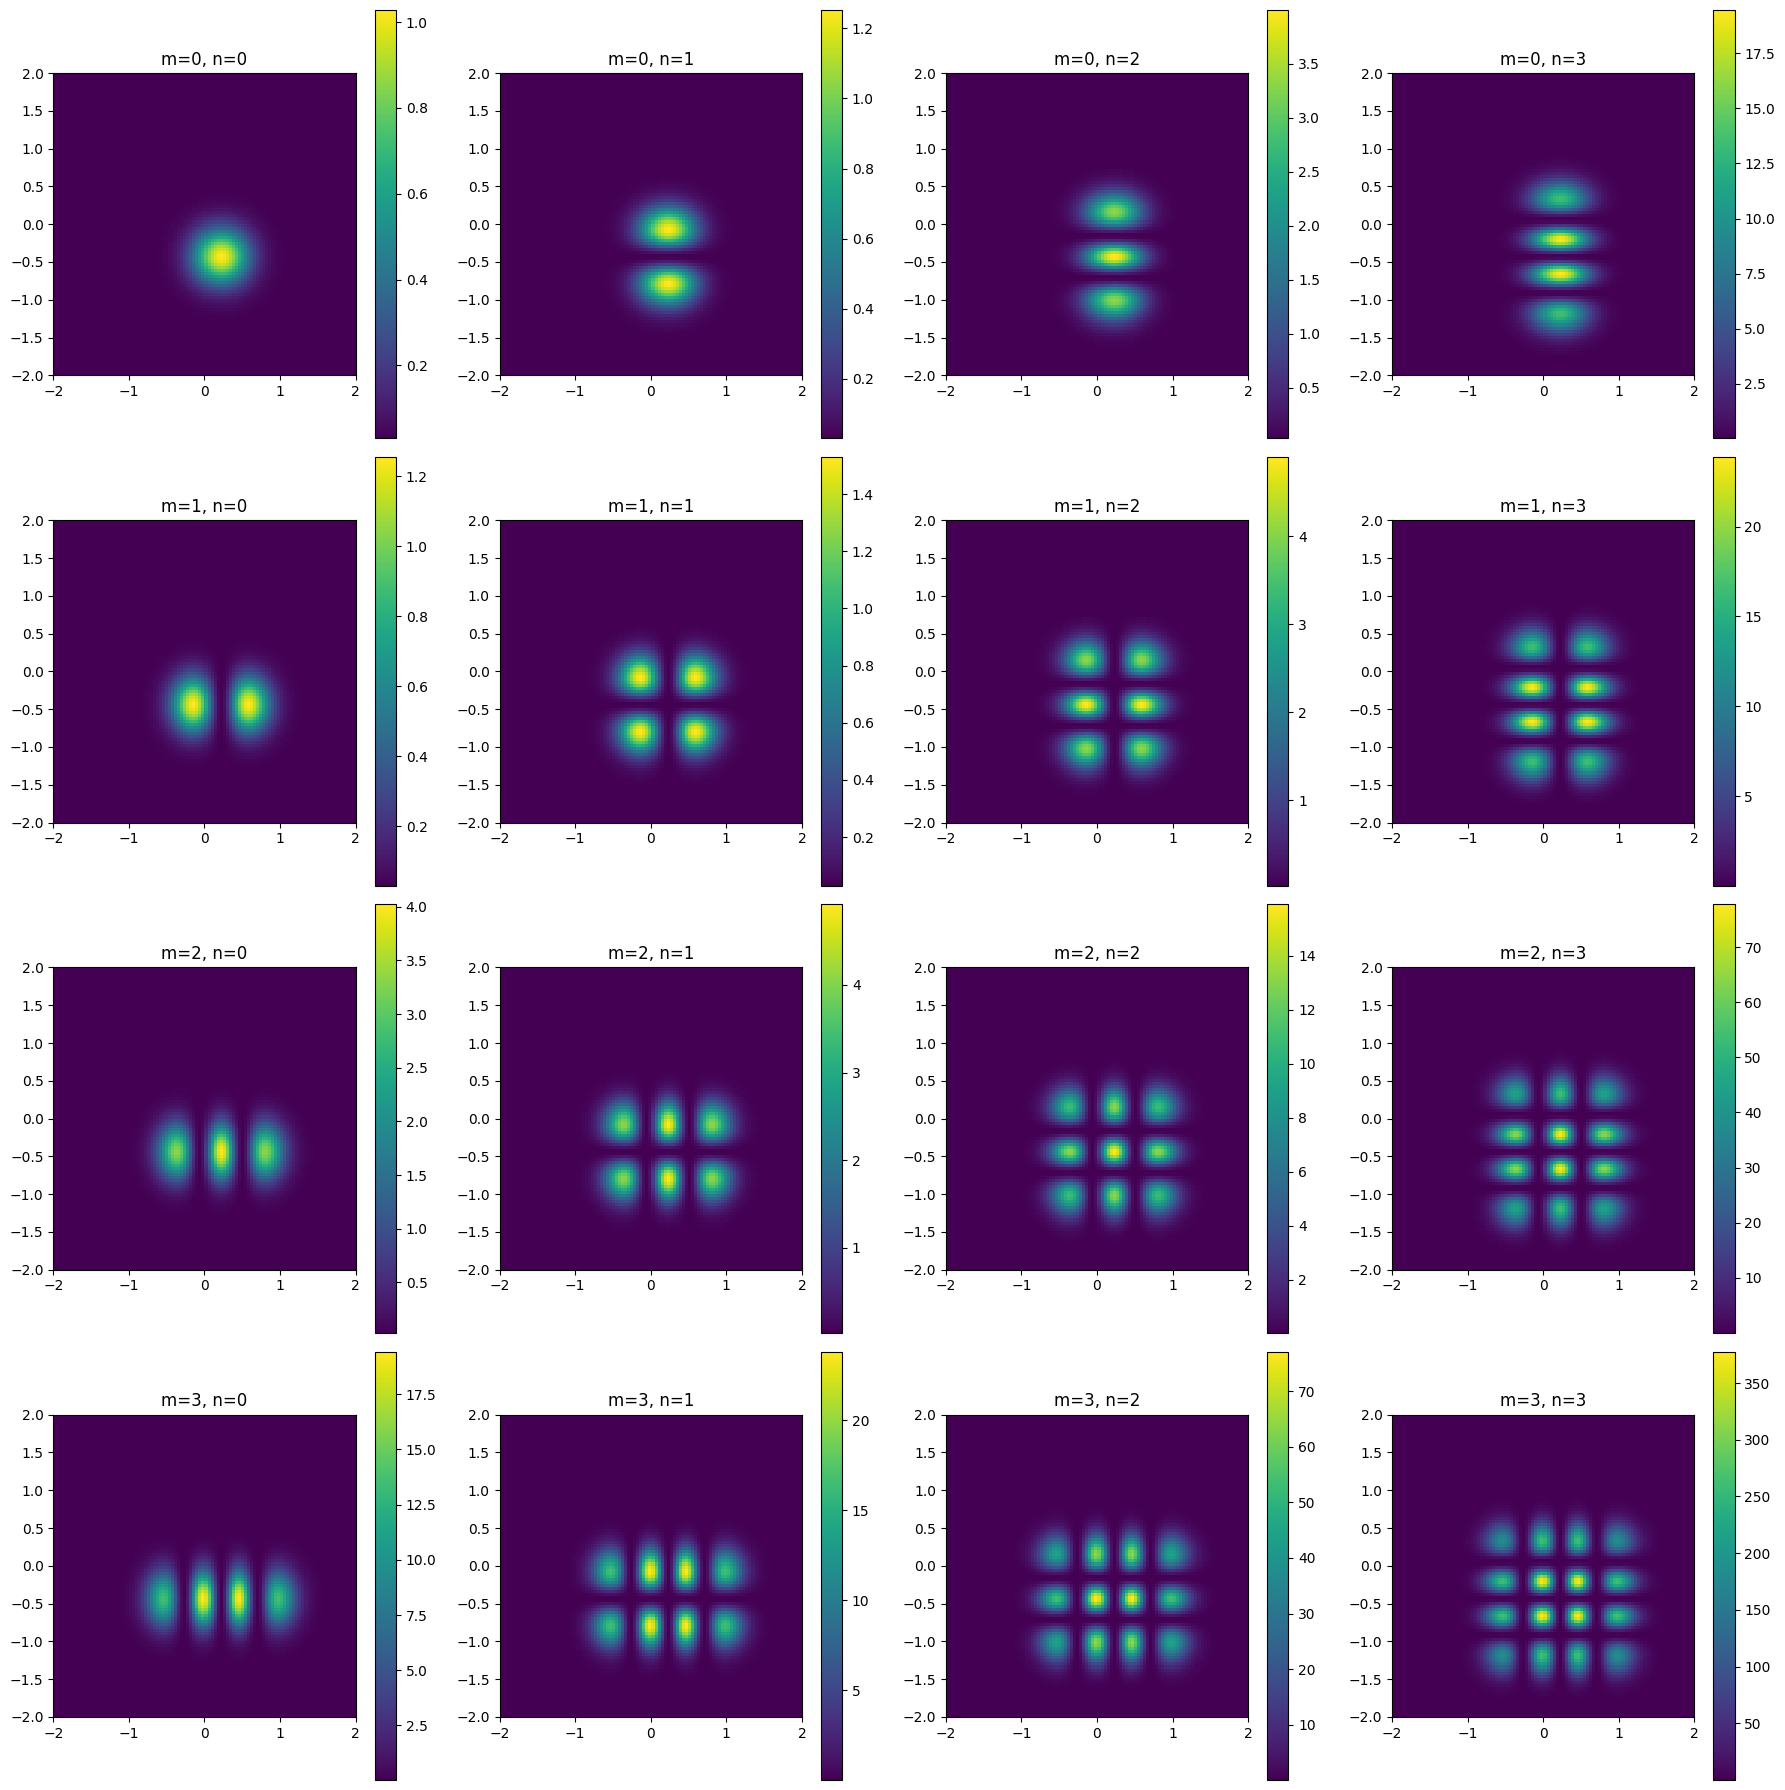

In [60]:
# Generate mesh grid for plotting
x_data = np.linspace(-2, 2, 100)
y_data = np.linspace(-2, 2, 100)
x_mesh, y_mesh = np.meshgrid(x_data, y_data)

# Parameters for the model
# params = [.11, .05, 2, 0.22, -0.44, 0.03, .49, .58]
a=1
b=.6
c=0
x_shift=0.22
y_shift=-0.44
z_offset=0.03
x_scale=2.5
y_scale=2.5
params = [a, b, c, x_shift, y_shift, z_offset, x_scale, y_scale]

m_max = 3
n_max = 3
# Create an array of plots for m and n from 0 to 1
fig, axes = plt.subplots(m_max + 1, n_max + 1, figsize=(18, 18))

# Loop over all combinations of m and n from 0 to 1
for m in range(m_max + 1):
    for n in range(n_max + 1):
        # Compute the model function with the mesh grid
        z_data = model_function(params, x_mesh, y_mesh, m, n)
        
        # Select the current axis for plotting
        ax = axes[m, n]
        
        # Plot the data
        c = ax.imshow(z_data, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis')
        ax.set_title(f'm={m}, n={n}')
        fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

In [61]:
# # Generate synthetic data
# np.random.seed(0)
# x_data = np.linspace(-2, 2, 50)
# y_data = np.linspace(-2, 2, 50)
# x_mesh, y_mesh = np.meshgrid(x_data, y_data)
# z_data = model_function((x_mesh.ravel(), y_mesh.ravel()), 1.0, 0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0) + 0.2 * np.random.normal(size=x_mesh.size)




In [62]:
# Load data from BMP file
def load_image(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = img.astype(np.float64) / 255.0  # Normalize to [0, 1]
    return img

m = 0
n = 1
z_data = load_image(f"./bmp/tem_{m}{n}.bmp")
y_size, x_size = z_data.shape
x_data = np.linspace(-2, 2, x_size)
y_data = np.linspace(-2, 2, y_size)
x_mesh, y_mesh = np.meshgrid(x_data, y_data)

# Estimate initial parameters for better convergence
z_offset_init = np.min(z_data)
z_data_centered = z_data - z_offset_init
a_init = np.max(z_data_centered) ** 0.5
b_init = 0.5  # Initial guess for Gaussian decay factor
c_init = 0.0  # Initial guess for Hermite-Gaussian shift
x_shift_init, y_shift_init = np.mean(x_data), np.mean(y_data)
x_scale_init, y_scale_init = 1.0, 1.0

# initial_params = [a_init, b_init, c_init, x_shift_init, y_shift_init, z_offset_init, x_scale_init, y_scale_init]
initial_params = params

In [63]:
# Flatten the mesh grid and the z_data for fitting
x_data_flat = x_mesh.flatten()
y_data_flat = y_mesh.flatten()
z_data_flat = z_data.flatten()


# # Fit the model to the flattened data
popt, pcov = curve_fit(
    lambda xy, *params: model_function(params, xy[0], xy[1], m, n),
    np.vstack((x_data_flat, y_data_flat)),
    z_data_flat,
    p0=initial_params
)

# popt = least_squares(lambda params: model_function(params, x_data, y_data, m, n) - z_data, params)



/Users/rockykamenrubio/Documents/freie_universitat/advanced_lab/feddie_repo/Advanced-Labs-FU-Berlin/advanced_lab_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/Users/rockykamenrubio/Documents/freie_universitat/advanced_lab/feddie_repo/Advanced-Labs-FU-Berlin/advanced_lab_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/rockykamenrubio/Documents/freie_universitat/advanced_lab/feddie_repo/Advanced-Labs-FU-Berlin/advanced_lab_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  


Fitted parameters: a=0.85, b=0.95, c=0.01, x_shift=0.83, y_shift=-0.48, z_offset=0.04, x_scale=-3.46, y_scale=2.18


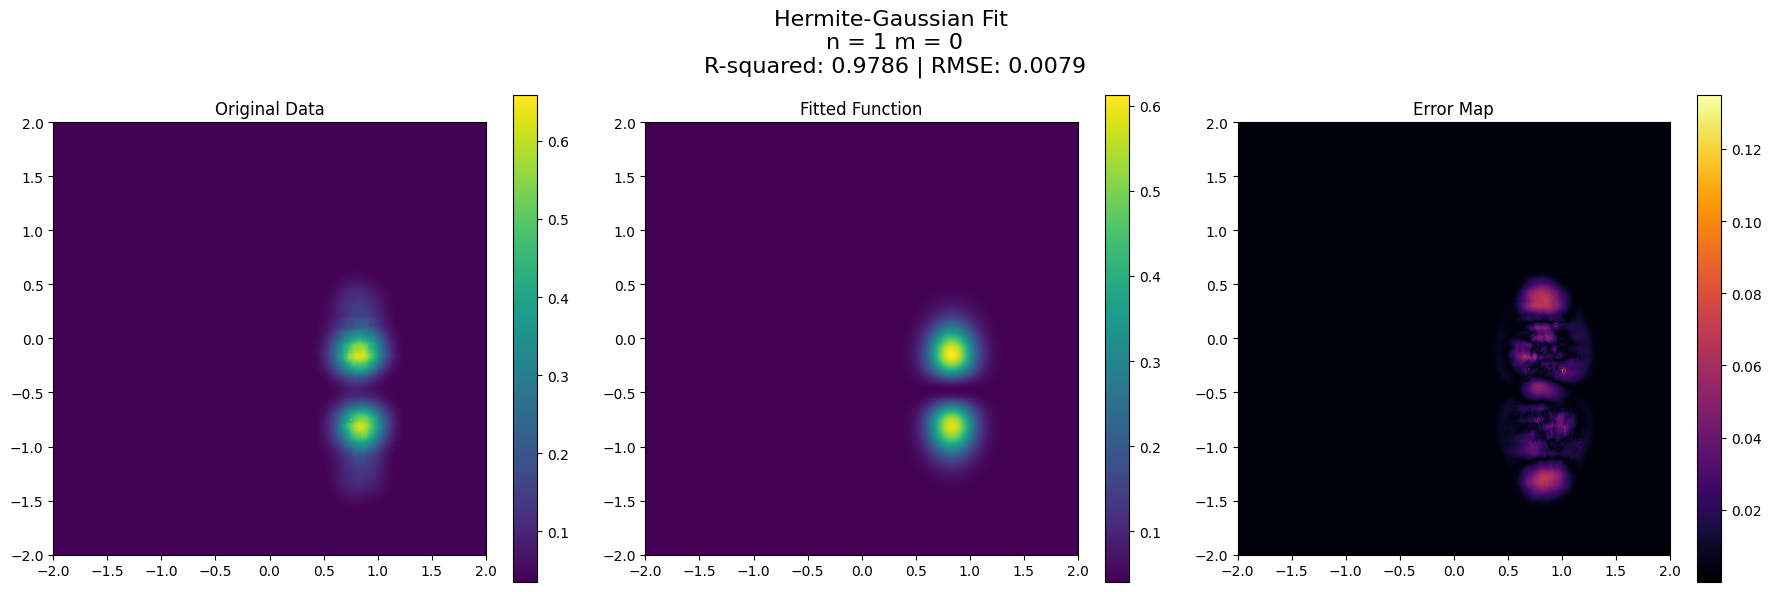

In [64]:
# Extract the fitted parameters
a_fit, b_fit, c_fit, x_shift_fit, y_shift_fit, z_offset_fit, x_scale_fit, y_scale_fit = popt
print(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}, x_shift={x_shift_fit:.2f}, y_shift={y_shift_fit:.2f}, z_offset={z_offset_fit:.2f}, x_scale={x_scale_fit:.2f}, y_scale={y_scale_fit:.2f}")

# Compute the fitted function values
z_fit_flat = model_function(popt, x_data_flat, y_data_flat, m, n)

# Reshape the fitted values back into the mesh grid shape
z_fit = z_fit_flat.reshape(x_mesh.shape)

# Compute error map and reshape
error_flat = np.abs(z_data_flat - z_fit_flat)
error = error_flat.reshape(x_mesh.shape)

# Calculate R-squared (coefficient of determination)
ss_res = np.sum((z_data_flat - z_fit_flat) ** 2)
ss_tot = np.sum((z_data_flat - np.mean(z_data_flat)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(z_data_flat, z_fit_flat))

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot original data
c1 = axes[0].imshow(z_data, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis')
axes[0].set_title('Original Data')
fig.colorbar(c1, ax=axes[0])

# Plot fitted function
c2 = axes[1].imshow(z_fit, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis')
axes[1].set_title('Fitted Function')
fig.colorbar(c2, ax=axes[1])

# Plot error map
c3 = axes[2].imshow(error, extent=[-2, 2, -2, 2], origin='lower', cmap='inferno')
axes[2].set_title('Error Map')
fig.colorbar(c3, ax=axes[2])

plt.suptitle(f'Hermite-Gaussian Fit \nn = {n} m = {m}\nR-squared: {r_squared:.4f} | RMSE: {rmse:.4f}', fontsize=16)
plt.tight_layout()
plt.show()

